## Use Starfish to obtain the needed data for segmentation

This notebook demonstrates a three step segmentation workflow leveraging a learned model using Ilastik: 
1. Load data and filter it using starfish to enhance the visible locations of the cells
2. Segment the data usign Ilastik
3. Post-process the segmentation probabilities using starfish to produce a SegmentationMaskCollection.

It does not yet demonstrate applying a learned model to a different field of view. 

In [1]:
%gui qt
%matplotlib inline

import matplotlib
import matplotlib.pyplot as plt
import numpy as np

import starfish
import starfish.data
from starfish.image import Filter
from starfish.types import Axes, Coordinates

In [2]:
# set figure DPI for screen viewing
matplotlib.rcParams["figure.dpi"] = 150

Get an example MERFISH field of view from starfish's data module:

In [3]:
merfish = starfish.data.MERFISH()
merfish

<starfish.Experiment (FOVs=496)>
{
fov_000: <starfish.FieldOfView>
  Primary Image: <slicedimage.TileSet (r: 8, z: 1, c: 2, x: 2048, y: 2048)>
  Auxiliary Images:
    nuclei: <slicedimage.TileSet (r: 1, z: 1, c: 1, x: 2048, y: 2048)>
fov_001: <starfish.FieldOfView>
  Primary Image: <slicedimage.TileSet (r: 8, z: 1, c: 2, x: 2048, y: 2048)>
  Auxiliary Images:
    nuclei: <slicedimage.TileSet (r: 1, z: 1, c: 1, x: 2048, y: 2048)>
fov_002: <starfish.FieldOfView>
  Primary Image: <slicedimage.TileSet (r: 8, z: 1, c: 2, x: 2048, y: 2048)>
  Auxiliary Images:
    nuclei: <slicedimage.TileSet (r: 1, z: 1, c: 1, x: 2048, y: 2048)>
fov_003: <starfish.FieldOfView>
  Primary Image: <slicedimage.TileSet (r: 8, z: 1, c: 2, x: 2048, y: 2048)>
  Auxiliary Images:
    nuclei: <slicedimage.TileSet (r: 1, z: 1, c: 1, x: 2048, y: 2048)>
  ...,
}

This example will segment one field of view based on the nuclear stain (DAPI)

In [4]:
def load_data(fov: str):
    fov = merfish[fov]
    dapi = fov.get_image("nuclei")
    primary = fov.get_image("primary")
    return dapi, primary

dapi, primary = load_data("fov_000")

In [6]:
%gui qt5

starfish.display(dapi)

The first thing to do is run some basic pre-processing filters to help visually identify the location of the nuclei. Note that Ilastik trains a classifier on the signal properties of the data, so this pre-processing will need to be applied to other images as well if your goal is to apply a pre-trained model built from a single field of view across multiple fields of view in your model. 

To highlight the nuclei, we clip the bottom percentile (assumed: noise) and top 5 percentiles, rescaling the image to fit in (0, 1). This emphasizes nuclear locations. 

Second, to eliminate minor intensity differences in the nuclei or cell body, we apply a gaussian blur. 

In [5]:
def preprocess(dapi):
    blur = Filter.GaussianLowPass(sigma=5)
    blurred = blur.run(dapi)

    clip = Filter.Clip(p_min=1, p_max=95, expand_dynamic_range=True)
    clipped = clip.run(blurred)
    return clipped

clipped = preprocess(dapi)

100%|██████████| 1/1 [00:00<00:00, 18.00it/s]


Visualize the clipped and blurred result. The cells look fairly obvious to the eye, but the downside is that these processing steps would need to be repeated prior to running the Ilastik classifer on new fields of view. Ideally you could look at an *unprocessed* field of view.

100%|██████████| 1/1 [00:00<00:00, 22.76it/s]


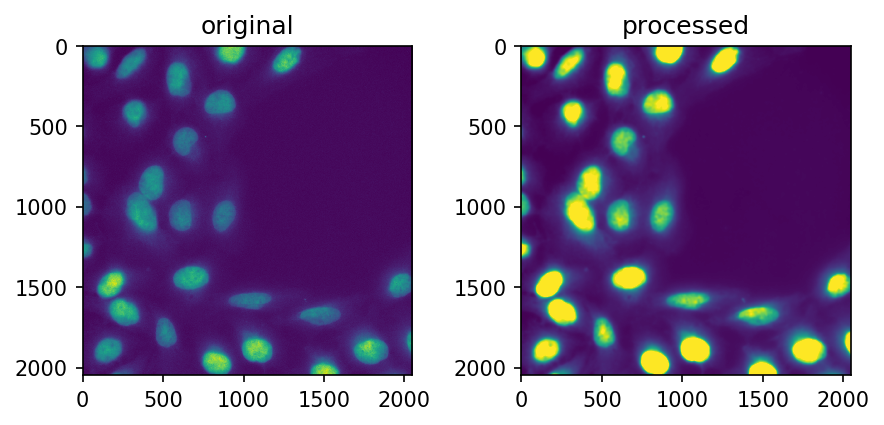

In [6]:
f, (ax1, ax2) = plt.subplots(ncols=2)
ax1.imshow(dapi.xarray.values.squeeze())
ax1.set_title("original")
ax2.imshow(clipped.xarray.values.squeeze())
ax2.set_title("processed")
f.tight_layout()

Ilastik can read .npy files, so that format is saved for segmentation. 

In [7]:
np.save('dapi.npy', clipped.xarray.values.squeeze())

The next step is to download Ilastik, create an ilastik project and follow a pixel classification workflow. They have a great demo which can be found here: https://www.ilastik.org/documentation/pixelclassification/pixelclassification

In [7]:
from starfish.image import Segment

segmenter = Segment.IllastikPretrained('/Users/shannonaxelrod/dev/starfish/notebooks/dapi_Probabilities.h5')

binary_masks = segmenter.run(primary, dapi)

/Users/shannonaxelrod/dev/starfish/starfish/core/image/Segment/illastik_pretrained.py:20: H5pyDeprecationWarning: The default file mode will change to 'r' (read-only) in h5py 3.0. To suppress this warning, pass the mode you need to h5py.File(), or set the global default h5.get_config().default_file_mode, or set the environment variable H5PY_DEFAULT_READONLY=1. Available modes are: 'r', 'r+', 'w', 'w-'/'x', 'a'. See the docs for details.
  h5 = h5py.File(path_to_ilastic_model)


ValueError: a 5-d tensor with shape (n_round, n_ch, n_z, y, x) must be provided.

We've trained a model ourselves following the pixel classification routine, which has output a file named `dapi_Probabilties.h5`, after the name of our output `.npy` file. 

While training, note that the number of training examples (labeled pixels) increases the amount of time needed to call probabilities. As a result, it's a good idea to label as few pixels as possible. In this example, we've labeled quite a large number of pixels, so our model takes a while to run. 

The Ilastik output is a very simple hdf5 file that contains an array of shape `(*input_dims, labels)`, which for starfish is `(y, x, labels)`

The next portion of the vignette reads the probability mask back into the python notebook. 

In [8]:
import h5py

def load_probabilities(h5file: str):
    h5 = h5py.File(h5file)
    print(f"h5 keys: {h5.keys()}")

    probability_images = h5["exported_data"][:]
    h5.close()

    print(f"exported_data shape: {probability_images.shape}, type: {type(probability_images)}")

    cell_probabilities, background_probabilities = probability_images[:, :, 0], probability_images[:, :, 1]
    
    return cell_probabilities, background_probabilities

cell_probabilities, background_probabilities = load_probabilities("dapi_Probabilities.h5")



h5 keys: <KeysViewHDF5 ['exported_data']>
exported_data shape: (2048, 2048, 2), type: <class 'numpy.ndarray'>


/Users/shannonaxelrod/dev/starfish/.venv/lib/python3.7/site-packages/ipykernel_launcher.py:4: H5pyDeprecationWarning: The default file mode will change to 'r' (read-only) in h5py 3.0. To suppress this warning, pass the mode you need to h5py.File(), or set the global default h5.get_config().default_file_mode, or set the environment variable H5PY_DEFAULT_READONLY=1. Available modes are: 'r', 'r+', 'w', 'w-'/'x', 'a'. See the docs for details.
  after removing the cwd from sys.path.


Below we plot the probabilities. The first plot is the foreground probability (cells) and the second is the background probability. We can see that the probability mask has allowed a few of the cells to merge, particularly in the center-left of the image. 

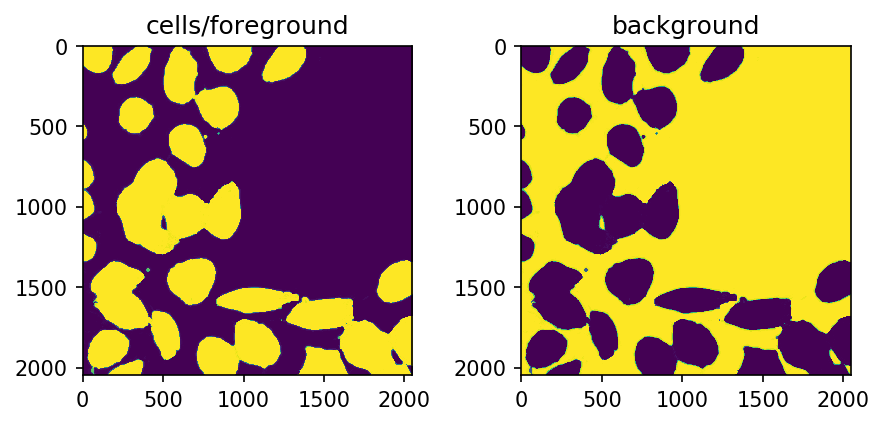

In [12]:
f, (a1, a2) = plt.subplots(ncols=2)
a1.imshow(cell_probabilities)
a1.set_title("cells/foreground")
a2.imshow(background_probabilities)
a2.set_title("background")
f.tight_layout()

If this image is transformed into a label image directly, the connections between neighboring objects cause cells to be merged. 

In [9]:
from skimage.filters import threshold_otsu
import scipy.ndimage as ndi
from starfish import ImageStack

cell_threshold = threshold_otsu(cell_probabilities)

initial_label = ndi.label(cell_probabilities > cell_threshold)[0]

initial_label = np.expand_dims(initial_label, axis=0)
initial_label = np.expand_dims(initial_label, axis=0)
initial_label = np.expand_dims(initial_label, axis=0)
initial_label.shape

stack = ImageStack.from_numpy(initial_label)
stack

# plt.imshow(initial_label, cmap=plt.cm.nipy_spectral)

/Users/shannonaxelrod/dev/starfish/starfish/core/imagestack/imagestack.py:351: UserWarning: ImageStack detected as int32. Converting to float32...
  warnings.warn(f"ImageStack detected as {array.dtype}. Converting to float32...")
/Users/shannonaxelrod/dev/starfish/.venv/lib/python3.7/site-packages/skimage/util/dtype.py:135: UserWarning: Possible precision loss when converting from int32 to float32
  .format(dtypeobj_in, dtypeobj_out))


<starfish.ImageStack (r: 1, c: 1, z: 1, y: 2048, x: 2048)>

In [10]:
from starfish.core.morphology.Binarize import ThresholdBinarize

binarizer = ThresholdBinarize(threshold=cell_threshold)
mask_collection = binarizer.run(stack)

mask_collection

100%|██████████| 1/1 [00:00<00:00, 50.75it/s]


In [11]:
%gui qt5

starfish.display(dapi, masks=mask_collection)

In [12]:
np.save('/Users/shannonaxelrod/dev/starfish/notebooks/ilastik_label_image.npy', initial_label)

We can use the Watershed method to declump these results. Python implementations of watershed have a few steps, which are nicely outlined in this skimage tutorial: https://scikit-image.org/docs/dev/auto_examples/segmentation/plot_watershed.html

In brief, one must create a "basin" that will be filled to a watershed line, which by default is the maximum value of the image, markers, which note the locations from which to begin filling, and a mask, which marks pixels that are eligible for being labeled. 

A decent method for creating the basin is to threshold the probability image as above, but then run a distance transform, where each pixel is replaced by its closest distance to a 0-valued pixel. Intuitively, this causes the center of a cell to have the largest value, which decreases as it gets closer to the membrance. Inverting this to be negative produces a basin that can be used for watershed. 

Markers are best created based on the nuclei, because nuclei rarely overlap, and that is likely to ensure that each nuclei is filled separately. 

Finally, the mask can be formed based on the thresholded probability image, and dilated or eroded to increase the segmented area. 

In [16]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import ndimage as ndi

from skimage.morphology import watershed
from skimage.feature import peak_local_max

In [17]:
nuclei_threshold = threshold_otsu(clipped.xarray.values.squeeze())
nuclei_mask = clipped.xarray.values.squeeze() > nuclei_threshold

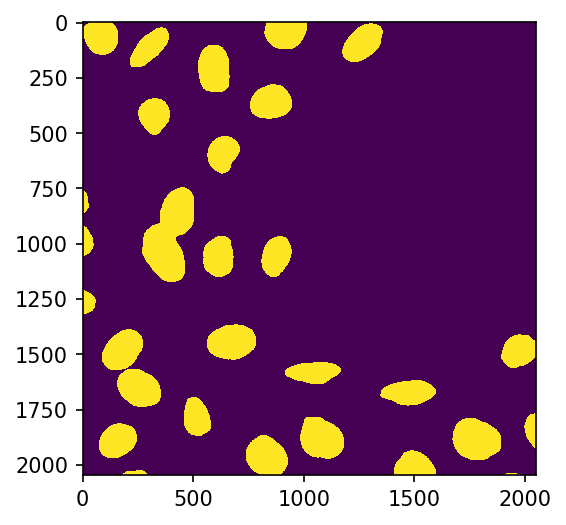

In [18]:
plt.imshow(nuclei_mask)

This is almost perfect, but two cells are touching. However, the shape is good enough that carefully setting the min_dist parameter of the local_max algorithm should produce a pair of markers here. 

In [19]:
distance = ndi.distance_transform_edt(nuclei_mask)

Take a look at the distribution of distances. We will use this to find the local maxima, which will be used as markers to initiate the watershed filling. 

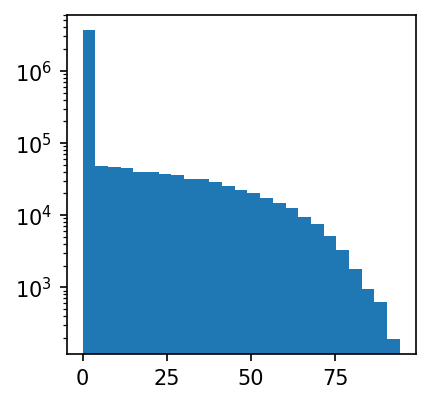

In [20]:
plt.figure(figsize=(3, 3))
plt.hist(distance.reshape(-1), log=True, bins=25);

The local max function for marker identification requires quite a bit of tweaking. What I've done here is: 
1. set `exclude_border=False`, since any cell that overlaps the border will find its maximum value there
2. set `threshold_abs=50` to exclude any non-cellular seeds
3. set `min_distance=50` to prevent over-segmentation of cells. 

In [21]:
peaks = peak_local_max(
    distance, indices=True, exclude_border=False, threshold_abs=40, min_distance=75
)

Note that this misses the very small fractional cells on the border. This is intentional. If one wanted to include them, decreasing the threshold_abs parameter would allow markers to be found for cells where the maximum distance was smaller. 

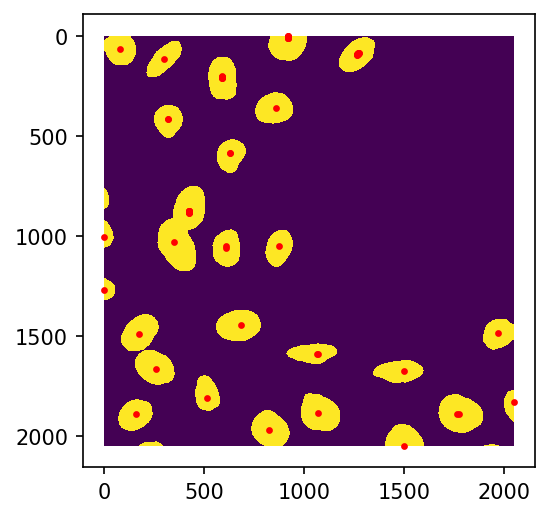

In [22]:
plt.figure(dpi=150)
plt.imshow(nuclei_mask)
plt.scatter(peaks[:, 1], peaks[:, 0], s=5, c='r')

Call peaks again, but set indices false to output the results as an image, as watershed requires, instead of as plottable coordintates. 

In [23]:
peaks = peak_local_max(
    distance, indices=False, exclude_border=False, threshold_abs=40, min_distance=75
)
markers = ndi.label(peaks)[0]

In [24]:
cell_mask = cell_probabilities > cell_threshold
label_image = watershed(-distance, markers, mask=cell_mask)

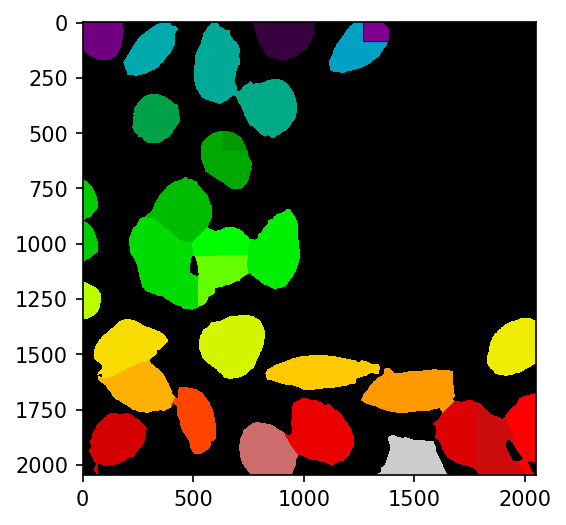

In [23]:
plt.imshow(label_image, cmap=plt.cm.nipy_spectral)

If one wants to control the segmentation space, it's simple to dilate (increase) or erode (decrease) the segmented area. 

In [25]:
from skimage.morphology import dilation, erosion, disk

In [26]:
structuring_element = disk(15)
eroded_mask = erosion(cell_mask, structuring_element)
dilated_mask = dilation(cell_mask, structuring_element)

In [27]:
eroded_watershed = watershed(-distance, markers, mask=eroded_mask)
dilated_watershed = watershed(-distance, markers, mask=dilated_mask)

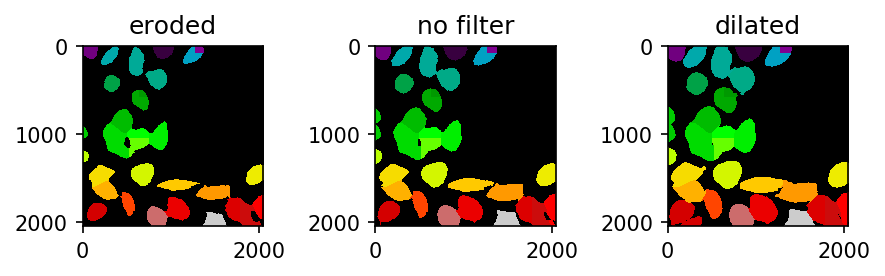

In [38]:
f, (a1, a2, a3) = plt.subplots(ncols=3)
a1.imshow(eroded_watershed, cmap=plt.cm.nipy_spectral)
a1.set_title("eroded")
a2.imshow(label_image, cmap=plt.cm.nipy_spectral)
a2.set_title("no filter")
a3.imshow(dilated_watershed, cmap=plt.cm.nipy_spectral)
a3.set_title("dilated")
f.tight_layout()

Finally, we can load the result back into starfish so that we can use these data to label the point clouds we've found with their cell of origin, and construct a cell x gene count matrix. 

In [107]:
physical_ticks={
    starfish.types.Coordinates.X: dapi.xarray.coords[starfish.types.Coordinates.X.value],
    starfish.types.Coordinates.Y: dapi.xarray.coords[starfish.types.Coordinates.Y.value]
}

In [40]:
collection = starfish.core.segmentation_mask.SegmentationMaskCollection.from_label_image(
    label_image, physical_ticks=physical_ticks
)

In [34]:
import PySide2

In [35]:
%gui qt5

starfish.display(dapi, masks=mask_collection)

TypeError: 'NoneType' object is not callable

## Do it all again, but for a new Field of View. 

The coolest thing about Ilastik is that you can train it on one field of view and then run it on a different one

In [44]:
fov = "fov_012"
dapi_fov_012 = load_data(f"{fov}")
clipped = preprocess(dapi_fov_012)
np.save(f"dapi_{fov}.npy", clipped.xarray.values.squeeze())

100%|██████████| 1/1 [00:00<00:00, 14.96it/s]


Paste the following text into bash, replacing your field of view or ilastik application location as needed. This should take only a few seconds. 

Note: This may *not* work in ipython `%%bash` magic due to virtual environments; Ilastik never seems able to find h5py. 


```bash
FOV="fov_012"
ILASTIK="/Applications/ilastik-1.3.2post1-OSX.app"

${ILASTIK}/Contents/ilastik-release/run_ilastik.sh \
    --headless \
    --project=dapi_segmentation.ilp \
    dapi_${FOV}.npy
```

The size of a cell should not have changed, so it should be reasonable to use the same peak calling parameters for finding the markers. As a result, we can now write a short function to run watershed. 

In [ ]:
def watershed_declump(dapi: starfish.ImageStack, probabilities: np.ndarray):
    # get the numpy array out of the ImageStack
    dapi_array = dapi.xarray.values.squeeze()
    
    # create the nuclei mask
    nuclei_threshold = threshold_otsu(dapi_array)
    nuclei_mask = dapi_array > nuclei_threshold
    
    # calculate the markers from a distance map of the nuclei mask
    distance = ndi.distance_transform_edt(nuclei_mask)
    peaks = peak_local_max(
        distance, indices=False, exclude_border=False, 
        threshold_abs=40, min_distance=75
    )
    markers = ndi.label(peaks)[0]
    
    # create a cell mask from the probabilities
    cell_threshold = threshold_otsu(probabilities)
    cell_mask = probabilities > cell_threshold
    
    # run the watershed
    label_image = watershed(-distance, markers, mask=cell_mask)
    
    # convert to a mask collection
    physical_ticks={
        starfish.types.Coordinates.X: dapi.xarray.coords[starfish.types.Coordinates.X.value],
        starfish.types.Coordinates.Y: dapi.xarray.coords[starfish.types.Coordinates.Y.value]
    }
    masks = starfish.core.segmentation_mask.SegmentationMaskCollection.from_label_image(
        label_image, physical_ticks=physical_ticks
    )
    
    return masks, nuclei_mask, markers, cell_mask

cell_probabilities, background_probabilities = load_probabilities("dapi_fov_012_Probabilities.h5")
fov_012_masks, nm, mk, cm = watershed_declump(clipped, cell_probabilities)

In [ ]:
starfish.display(dapi_fov_012, masks=fov_012_masks)

This segmentation is better, but still clumpy. 

TODO try on third field of view, but also refine the marker positions. This will require some iteration to match the signal properties across the datasets. It also doesn't do a great job of marking the point clouds and probably misses data. More careful labeling, or feature selection, could be useful to refine. 

## Compare to Starfish watershed segmentation

100%|██████████| 1/1 [00:00<00:00, 131.29it/s]


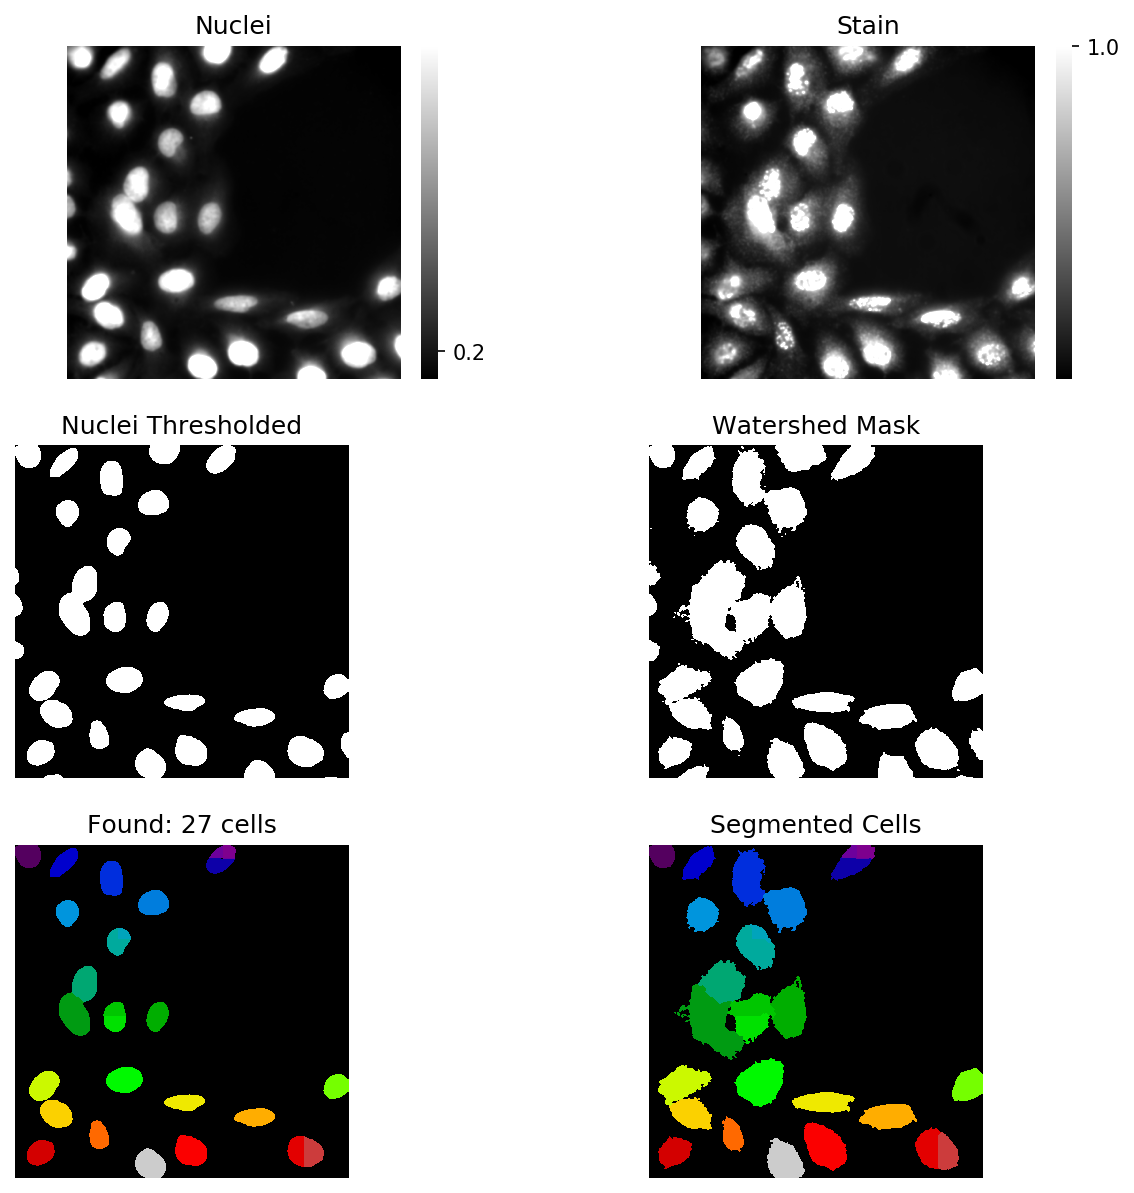

In [74]:
from starfish.image import Segment

fov = merfish['fov_000']
stack = fov.get_image(fov.PRIMARY_IMAGES)
stack = stack.max_proj(Axes.CH, Axes.ROUND)

blur = Filter.GaussianLowPass(sigma=5)
blurred = blur.run(stack)

clip = Filter.Clip(p_min=1, p_max=95, expand_dynamic_range=True)
stack_new = clip.run(blurred)

min_dist = 57

stain = stack_new
nuclei = clipped

seg = Segment.Watershed(
    nuclei_threshold= threshold_otsu(nuclei.xarray.values[0,0,0,:,:])*1.0, 
    input_threshold = threshold_otsu(stain.xarray.values[0,0,0,:,:])*.7,
    min_distance = min_dist
)

masks = seg.run(stain, nuclei)
seg.show()

In [48]:
dapi

<starfish.ImageStack (r: 1, c: 1, z: 1, y: 2048, x: 2048)>

In [55]:
from skimage.filters import threshold_otsu

threshold_otsu(nuclei.xarray.values[0,0,0,:,:])

0.5137137

In [54]:
nuclei

<starfish.ImageStack (r: 1, c: 1, z: 1, y: 2048, x: 2048)>

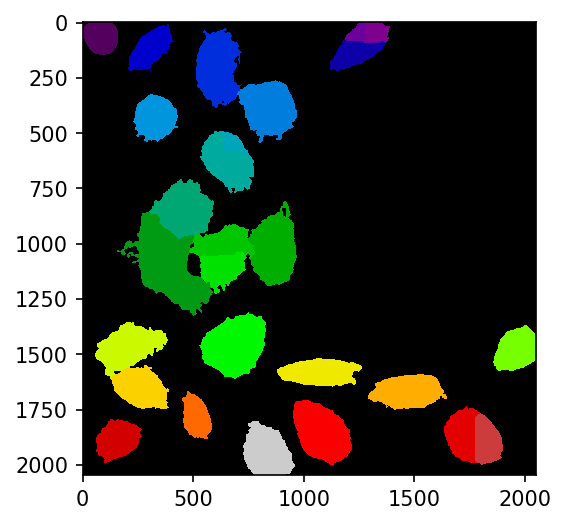

In [88]:
plt.imshow(masks.to_label_image(), cmap=plt.cm.nipy_spectral)

In [96]:
np.save('/Users/dganguli/src/starfish/notebooks/watershed_label_image.npy', masks.to_label_image())

In [63]:
blur = Filter.GaussianLowPass(sigma=5)
blurred = blur.run(stack)

clip = Filter.Clip(p_min=1, p_max=95, expand_dynamic_range=True)
stack_new = clip.run(blurred)



In [64]:
stack_new.xarray.min()

<xarray.DataArray ()>
array(0.205564, dtype=float32)

In [66]:
stack_new.xarray.max()

<xarray.DataArray ()>
array(1., dtype=float32)

In [73]:
seg.run?

In [97]:
ilas = np.load('/Users/dganguli/src/starfish/notebooks/ilastik_label_image.npy')
wate = np.load('/Users/dganguli/src/starfish/notebooks/watershed_label_image.npy')
fiji = np.load('/Users/dganguli/src/starfish/notebooks/fiji_label_image.npy')

ilas.shape, wate.shape, fiji.shape

((2048, 2048), (2048, 2048), (2048, 2048))

Text(0.5, 1.0, 'FIJI ROI')

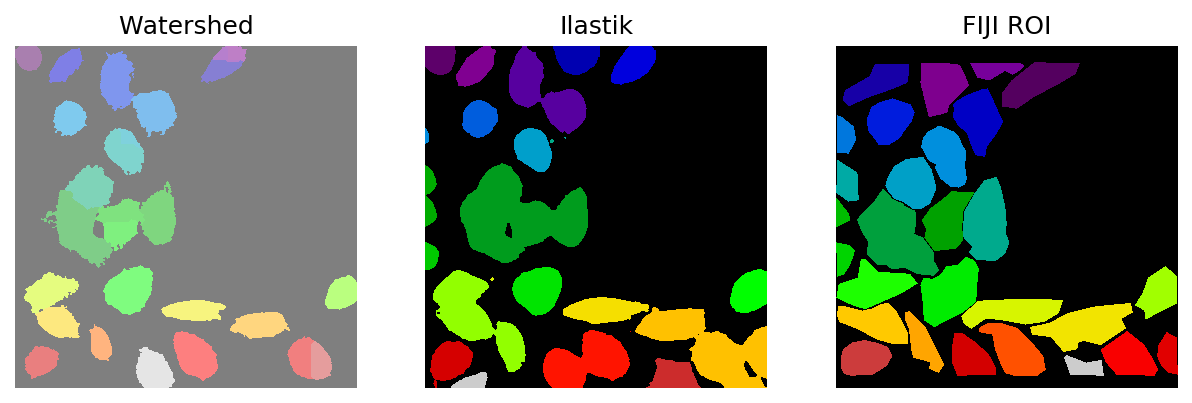

In [105]:
plt.figure(figsize=(10,10))
plt.subplot(131)
plt.imshow(wate, cmap=plt.cm.nipy_spectral)
plt.axis('off')
plt.title('Watershed')
plt.subplot(132)
plt.imshow(ilas, cmap=plt.cm.nipy_spectral)
plt.axis('off')
plt.title('Ilastik')
plt.subplot(133)
plt.imshow(fiji, cmap=plt.cm.nipy_spectral)
plt.axis('off')
plt.title('FIJI ROI')




In [110]:
wate_masks = starfish.core.segmentation_mask.SegmentationMaskCollection.from_label_image(
    wate, physical_ticks=physical_ticks
)

ilas_masks = starfish.core.segmentation_mask.SegmentationMaskCollection.from_label_image(
    ilas, physical_ticks=physical_ticks
)

fiji_masks = starfish.core.segmentation_mask.SegmentationMaskCollection.from_label_image(
    fiji, physical_ticks=physical_ticks
)

In [115]:
starfish.display(stack, masks=wate_masks)

In [117]:
starfish.display(stack, masks=ilas_masks)

In [119]:
starfish.display(stack, masks=fiji_masks)

In [112]:
%gui qt5